In [1]:
#‘01235’, ‘4’, ‘6’
#'012345', '6'
clustering_result=['01235','4', '6']

In [2]:
import os, sys

path_name = os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd())))
sys.path.append(path_name)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from Engine.Data.IO import IO
from Engine.Pipeline.pipeline import NextoptBasePipeline,NextoptWeekdayDMPipeline,NextoptWeekdayDMProphetPipeline
from Engine.Data.IO import IO
from Engine.Data.transformer import Transformer
from Engine.Data.explorer import Explorer

# 1. Input
path_name = os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd())))
sys.path.append(path_name)
print(path_name)

data_dir = path_name + '/Data/DB'

df_pallets = IO.read_pickle(data_dir + '/KPP일별_발주_유형별전처리.pkl') 
# 2. Transformer
df_pallets.head()
df_pallets.transformer.dt_format = '%Y%m%d' 

df_N11 = df_pallets.transformer.get(code=['N11'], weekday=[0,1,2,3,4,5,6],start='2012-01-01', end='2017-12-31').fillna(0.0)
df_L14 = df_pallets.transformer.get(code=['L14'], weekday=[0,1,2,3,4,5,6],start='2012-01-01', end='2017-12-31').fillna(0.0)
df_P11 = df_pallets.transformer.get(code=['P11'], weekday=[0,1,2,3,4,5,6],start='2012-01-01', end='2017-12-31').fillna(0.0)
df_P13= df_pallets.transformer.get(code=['P13'], weekday=[0,1,2,3,4,5,6],start='2012-01-01', end='2017-12-31').fillna(0.0)
df_P14= df_pallets.transformer.get(code=['P14'], weekday=[0,1,2,3,4,5,6],start='2012-01-01', end='2017-12-31').fillna(0.0)
df_set=[df_N11,df_L14,df_P11,df_P13,df_P14]

/Users/moonygo/Documents/NextoptEngine_light


SET INDEX AS DS(DateTimeIndex)
CROSS VALIDATION SPLIT IS DONE.
DIVIDE TRAIN BY WEEKDAY
DIVIDE EACH FOLD BY WEEKDAY
FOLD  1  DIVISION  1  RESET TRAIN, TEST INDEX FOR PROPHET MODEL


/anaconda3/envs/nextopt/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


FOLD  1  DIVISION  2  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  1  DIVISION  3  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  2  DIVISION  1  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  2  DIVISION  2  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  2  DIVISION  3  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  3  DIVISION  1  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  3  DIVISION  2  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  3  DIVISION  3  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  4  DIVISION  1  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  4  DIVISION  2  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  4  DIVISION  3  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  5  DIVISION  1  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  5  DIVISION  2  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  5  DIVISION  3  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  6  DIVISION  1  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  6  DIVISION  2  RESET TRAIN, TEST 

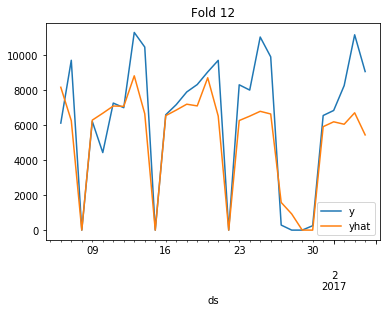

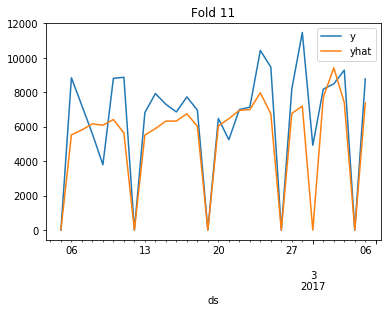

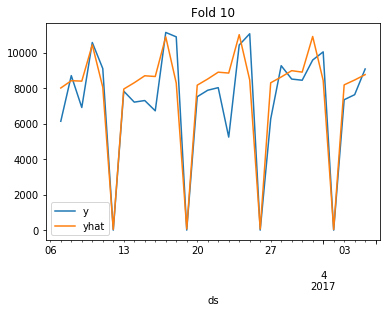

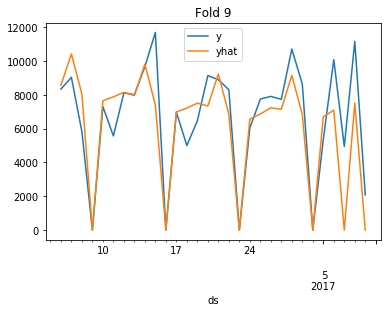

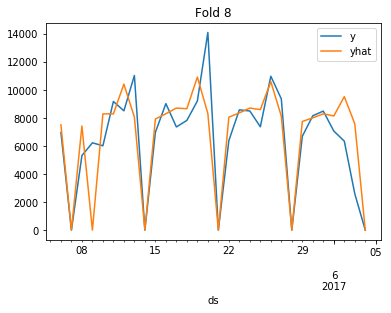

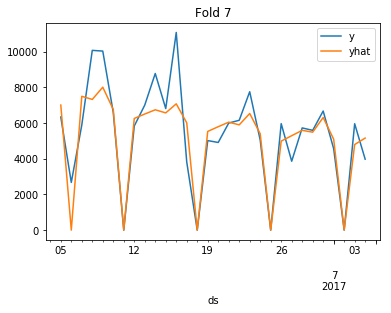

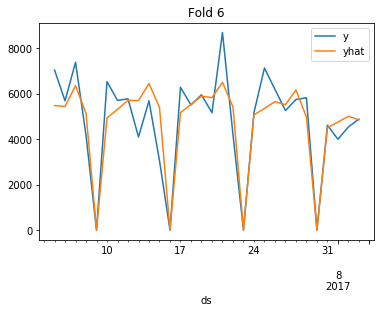

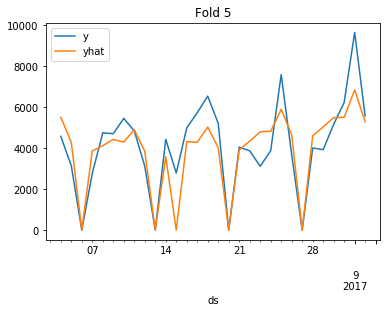

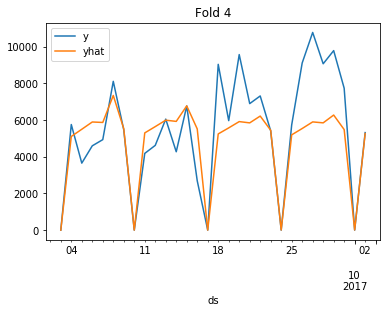

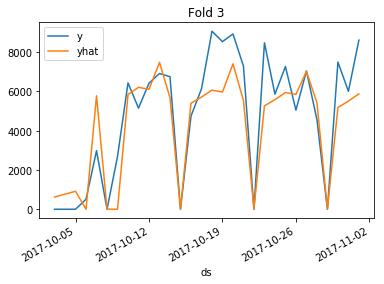

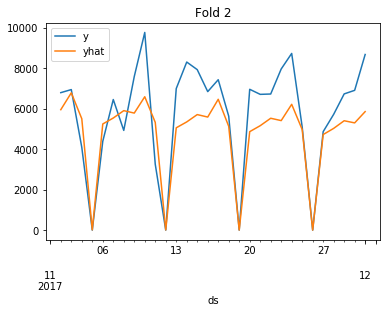

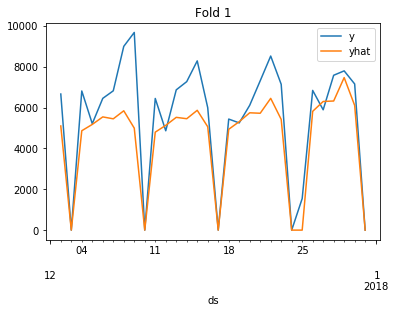

In [3]:
df = df_pallets.transformer.get(code=['P11'], weekday=[0,1,2,3,4,5,6],start='2012-01-01', end='2017-12-31')
df = df.fillna(0)
df = df.reset_index()
df.columns = ['ds','y']

pipeline = NextoptWeekdayDMProphetPipeline()
pipeline.raw_data = df
pipeline.horizon = 30 # 예측할 기간(defualt: 30)
pipeline.unit = 'd'

df_holiday_main = IO.read_pickle('../../Data/기타/holiday/1. 설날과추석.pkl')
df_holiday_sub = IO.read_pickle('../../Data/기타/holiday/2. 일반공휴일.pkl')
df_holiday_main['lower_window'] = 0
df_holiday_main['upper_window'] = 0
df_holiday_main['holiday'] = '중요휴일'

df_holiday_sub['lower_window'] = 0
df_holiday_sub['upper_window'] = 0
df_holiday_sub['holiday'] = '보통휴일'

df_holidays = pd.concat([df_holiday_main, df_holiday_sub])

pipeline.cross_validation_split(fold = 12)

#pipeline.division_condition = ['0','1','2','3','4','5','6'] # mon - thur, sat, sun
#pipeline.division_condition=['01234','5','6']
#pipeline.division_condition=['012345','6']
pipeline.division_condition = clustering_result
pipeline.division_condition

pipeline.model = Prophet(
        daily_seasonality= False,
        weekly_seasonality= True,
        yearly_seasonality= True,
        holidays = df_holidays
)
pipeline.fit_and_predict()
pipeline.merge_forecast()

pipeline.postprocess(holiday_correction_dict={0: df_holiday_main,
                                          0: df_holiday_sub
                                         })
pipeline.evaluate()
pipeline.print_summary()
pipeline.plot_forecast()

In [4]:
pipeline.print_summary()

    Fold       From         To      Real    Predict     Error  Error(%)  \
12    12 2017-01-06 2017-02-04  190977.0  159047.40  31929.60     16.72   
11    11 2017-02-05 2017-03-06  191849.0  159612.97  32236.03     16.80   
10    10 2017-03-07 2017-04-05  218923.0  229847.86 -10924.86     -4.99   
9      9 2017-04-06 2017-05-05  200771.0  186160.19  14610.81      7.28   
8      8 2017-05-06 2017-06-04  198186.0  204502.12  -6316.12     -3.19   
7      7 2017-06-05 2017-07-04  162202.0  153767.54   8434.46      5.20   
6      6 2017-07-05 2017-08-03  144374.0  142219.59   2154.41      1.49   
5      5 2017-08-04 2017-09-02  123574.0  117475.94   6098.06      4.93   
4      4 2017-09-03 2017-10-02  162827.0  144153.07  18673.93     11.47   
3      3 2017-10-03 2017-11-01  142921.0  126432.29  16488.71     11.54   
2      2 2017-11-02 2017-12-01  172469.0  144428.42  28040.58     16.26   
1      1 2017-12-02 2017-12-31  166885.0  134344.71  32540.29     19.50   

    Total Error  Total E

In [7]:
a= 45269 +42324.49+29902.74 + 38912.85 + 43847.37+ 28476.98+21149.28+26169.06+ 40319.07 +33157.64+38723.30+34006.25      

In [9]:
a/360

1172.9389722222222